In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils import to_categorical
from PIL import Image
from PIL import ImageFilter
import os
from random import sample
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.models import Model # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import  confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tf.keras.applications.resnet50 import ResNet50

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
size=300
b_size=16

# Loading dataset

In [ ]:
train=pd.read_csv('../input/aptos2019-blindness-detection/train.csv',dtype=str)
test=pd.read_csv('../input/aptos2019-blindness-detection/test.csv',dtype=str)
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
train['id_code']=train['id_code'].map(lambda x: '../input/aptos2019-blindness-detection/train_images/'+x+'.png')

In [ ]:
print(len(train),len(test))

3662 1928


# EDA of data

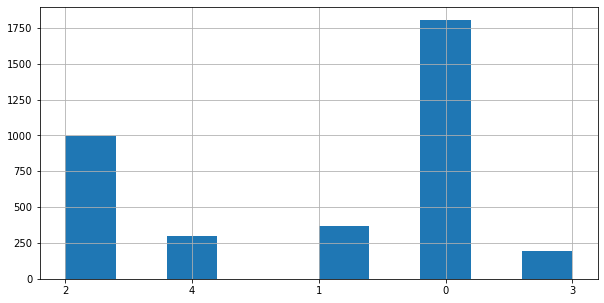

In [ ]:
train['diagnosis'].hist(figsize=(10,5))

Ploting sample images for each class

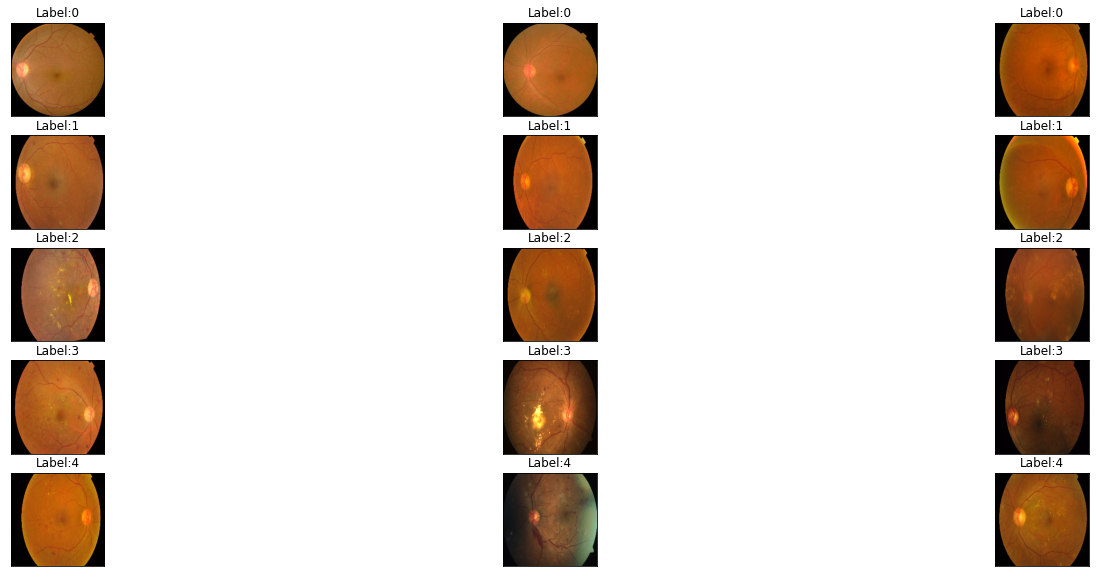

In [ ]:
fig = plt.figure(figsize=(25,10))
for id in range(5):
    spl=train[train['diagnosis']==str(id)].sample(3)
    for i,j in enumerate(spl['id_code']):
        ax=fig.add_subplot(5,3, (id * 3) + i + 1,xticks=[], yticks=[])
        img=cv2.imread(j)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (200, 200))
        ax.set_title('Label:'+str(id))
        plt.imshow(img)

Ploting sample images for each class

# Creating and saving augmented images

In [ ]:
train_0=train[train['diagnosis']!=str(0)]
train_rest=train_0[train_0['diagnosis']!=str(2)]

In [ ]:
#creating horizontal_flip and vertical_flip augmented images in order to deal with class imbalance 
def save_augments(img):
    
    def horizontal_flip(img):
        data_gen=ImageDataGenerator(horizontal_flip=True)
        img=np.expand_dims(img, 0)
        it = data_gen.flow(img, batch_size=1)
        batch = it.next()
        image = batch[0].astype('uint8')
        im = Image.fromarray(image)
        return im
    def vertical_flip(img):
        data_gen=ImageDataGenerator(vertical_flip=True)
        img=np.expand_dims(img, 0)
        it = data_gen.flow(img, batch_size=1)
        batch = it.next()
        image = batch[0].astype('uint8')
        im = Image.fromarray(image)
        return im 
    
    
    img1=horizontal_flip(img)
    img2=vertical_flip(img)
    return img1 ,img2

In [ ]:
a=[]
for i in range(len(train_rest)):
    a.append(i)
temp=sample(a,700)

In [ ]:
#creating augmented data and saving it 
os.makedirs('./aug_image')
for i in temp:
    img= cv2.imread(list(train_rest['id_code'])[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1,img2=save_augments(img)
    img1.save('./aug_image/'+str(1)+list(train_rest['id_code'])[i].split('/')[-1])
    img2.save('./aug_image/'+str(2)+list(train_rest['id_code'])[i].split('/')[-1])

In [ ]:
#loading the augmented data and storing the path in a dataframe
train_final=pd.DataFrame(columns=['id_code','diagnosis'])
list1=list(train['id_code'])
list2=list(train['diagnosis'])
files=os.listdir('../input/anwoy/aug_image')
for f in files:
    list1.append('../input/anwoy/aug_image/'+f)
    temp=train[train['id_code']=='../input/aptos2019-blindness-detection/train_images/'+f[1:]]
    list2.append(list(temp['diagnosis'])[0])
train_final['id_code']=list1
train_final['diagnosis']=list2

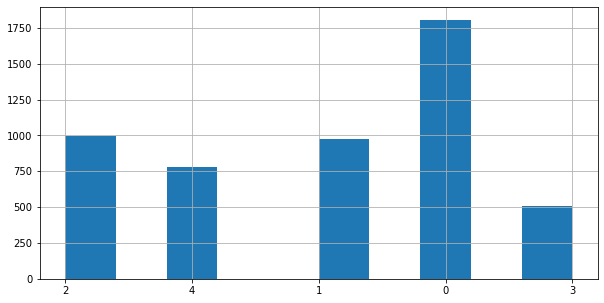

In [ ]:
train_final['diagnosis'].hist(figsize=(10,5))

After augmentation we can see the class imbalance is reduced to some extent 

# Image preprocessing

In [ ]:
#https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
# this function corp images by looking at the pixel intencity i.e considering those pixel whose values are greater than a given value  
def crop(img,maxi=7):
    if img.ndim ==2:
        mask = img>maxi
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        
        img_ = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = img_>maxi
        
        shape_ = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (shape_ == 0):
            return img 
        else:
            img_1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img_2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img_3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            image = np.stack([img_1,img_2,img_3],axis=-1)
        
        return image

In [ ]:
# function to enhance the image pixel values in order to make more interpretable.
def preprocessing(img):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = crop(img)
    img = cv2.resize(img, (size, size))
    img = cv2.addWeighted (img,4, cv2.GaussianBlur(img, (0,0) ,10), -4, 128)
    
    return img

In [ ]:
# canny edge detector helps in  finding imortant edges from a image by  removeing backgroung noise. 
def edge_detector(img):
    img = preprocessing(img)
    edges=cv2.Canny(img,300,330)
    return edges

In [ ]:
def threshold(img):
    img=preprocessing(img)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print(gray.shape)
    blurred = cv2.GaussianBlur(img, (1,1), 0)
    thresh = cv2.threshold(blurred, 135,255, cv2.THRESH_BINARY)[1]
    #thresh=cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    
    return thresh.astype('float32')/255

In [ ]:
t=train[train['diagnosis']==str(4)].sample(1)
list(t['id_code'])

['../input/aptos2019-blindness-detection/train_images/247e98aba610.png']

(Text(0.5, 1.0, 'Edge Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

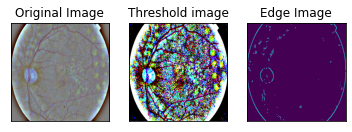

In [ ]:
img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+'247e98aba610.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pre=preprocessing(img)
#plt.imshow(pre)
plt.subplot(131),plt.imshow(pre)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(threshold(img))
plt.title('Threshold image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(edge_detector(img))
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

From the plot its clear that canny edge detector is not working properly hence we will use thresohlding image for training

# loading data for training

In [ ]:
train_set,valid_set=train_test_split(train_final)

In [ ]:
def image_aug(df):
    data_gen=ImageDataGenerator(preprocessing_function=threshold)
    train_generator=data_gen.flow_from_dataframe(df, 
                                                x_col='id_code', 
                                                y_col='diagnosis',
                                                #directory = '../input/aptos2019-blindness-detection/train_images',
                                                target_size=(size,size),
                                                batch_size=b_size,
                                                class_mode="categorical"
                                                )
    return train_generator

In [ ]:
train_generator=image_aug(train_set)
valid_generator=image_aug(valid_set)

In [ ]:
import tensorflow.keras.backend as K
def auc2(y_true,y_pred):
    try:
        return roc_auc_score(K.eval(y_true), K.eval(y_pred))
    except :
        return 0
def auc(y_true,y_pred):
    return tf.py_function(auc2,(y_true,y_pred),tf.double)

# Modeling

> >  ****Base model****

In [ ]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(300, 300, 3))
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
tf.keras.backend.clear_session()
Input_Layer = Input(shape=(size,size,3),name='Input_Layer')
vgg_out=vgg(Input_Layer)
flatten = Flatten(name='Flatten')(vgg_out)
Out = Dense(units=5,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=0),name='Output')(flatten)
base_model = Model(inputs=Input_Layer,outputs=Out)
base_model.summary()

In [ ]:
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=[auc])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00005)
base_model.fit(train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[reduce_lr],
        epochs=15)

In [ ]:
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
id_code = test_csv['id_code']
test_prediction = np.empty(len(id_code))
for i in range(len(id_code)):
    image = cv2.imread('../input/aptos2019-blindness-detection/test_images/'+list(test_csv['id_code'])[i]+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = base_model.predict(X)
    pred=np.argmax(pred,axis=1)
    test_prediction[i]=pred[0]
        
test_csv['diagnosis']=test_prediction
test_csv['diagnosis']=test_csv['diagnosis'].astype('int64')
test_csv.to_csv("submission.csv", index=False)
    

In [ ]:
valid_set=train_final.sample(1000)
y_pred = np.empty(len(valid_set))
for i in range(len(valid_set)):
    image = cv2.imread(list(valid_set['id_code'])[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = base_model.predict(X)
    pred=np.argmax(pred,axis=1)
    y_pred[i]=pred[0]

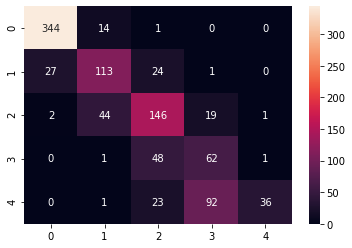

In [ ]:
sns.heatmap(confusion_matrix(list(valid_set['diagnosis'].astype('int64')),y_pred),annot=True, fmt="d")

> > **CNN model**

In [ ]:
Input_Layer = Input(shape=(size,size,3),name='Input_Layer')
x=Conv2D(filters=32,kernel_size=(1,1),strides=(3,3),kernel_initializer=tf.keras.initializers.he_normal(seed=0))(Input_Layer)
x=BatchNormalization(axis=3)(x)
x=Activation('relu')(x)
x=Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),kernel_initializer=tf.keras.initializers.he_normal(seed=0))(Input_Layer)
x=BatchNormalization(axis=3)(x)
x=Activation('relu')(x)
x=Conv2D(filters=64,kernel_size=(1,1),strides=(3,3),padding='same',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(Input_Layer)
x=BatchNormalization(axis=3)(x)
x=Activation('relu')(x)
x=Flattern()(x)
Out = Dense(units=5,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=0),name='Output')(flatten)
cnn_model = Model(inputs=Input_Layer,outputs=Out)
cnn_model.summary()

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=[auc])
cnn_model.fit(train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[reduce_lr],
        epochs=20)    
             

In [ ]:
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
id_code = test_csv['id_code']
test_prediction_1 = np.empty(len(id_code))
for i in range(len(id_code)):
    image = cv2.imread('../input/aptos2019-blindness-detection/test_images/'+list(test_csv['id_code'])[i]+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = cnn_model.predict(X)
    pred=np.argmax(pred,axis=1)
    test_prediction_1[i]=pred[0]
        
test_csv['diagnosis']=test_prediction_1
test_csv['diagnosis']=test_csv['diagnosis'].astype('int64')
test_csv.to_csv("submission.csv", index=False)

In [ ]:
y_pred = np.empty(len(valid_set))
for i in range(len(valid_set)):
    image = cv2.imread(list(valid_set['id_code'])[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = cnn_model.predict(X)
    pred=np.argmax(pred,axis=1)
    y_pred[i]=pred[0]
    

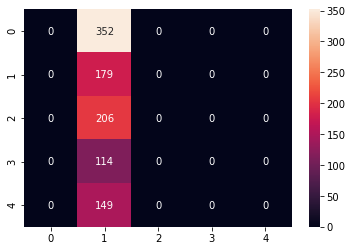

In [ ]:
sns.heatmap(confusion_matrix(list(valid_set['diagnosis'].astype('int64')),y_pred),annot=True, fmt="d")

> > **Transfer learning**

In [ ]:
Eff = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(size,size,3))
x = Eff.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs=Eff.input, outputs=x)
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=[auc])
model.fit(train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[reduce_lr],
        epochs=10)

In [ ]:
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
id_code = test_csv['id_code']
test_prediction_3 = np.empty(len(id_code))
for i in range(len(id_code)):
    image = cv2.imread('../input/aptos2019-blindness-detection/test_images/'+list(test_csv['id_code'])[i]+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = model.predict(X)
    pred=np.argmax(pred,axis=1)
    test_prediction_3[i]=pred[0]
        
test_csv['diagnosis']=test_prediction_3
test_csv['diagnosis']=test_csv['diagnosis'].astype('int64')
test_csv.to_csv("submission.csv", index=False)

In [ ]:
y_pred = np.empty(len(valid_set))
for i in range(len(valid_set)):
    image = cv2.imread(list(valid_set['id_code'])[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = model.predict(X)
    #pred=np.argmax(pred,axis=1)
    y_pred[i]=pred[0][0]

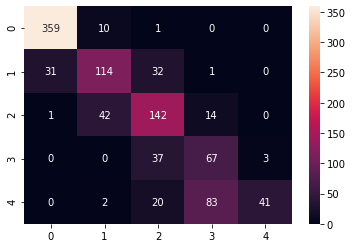

In [ ]:
sns.heatmap(confusion_matrix(list(valid_set['diagnosis'].astype('int64')),y_pred),annot=True, fmt="d")

> > ****Ensemble****

In [ ]:
Resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(size,size,3))
x = Resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)
model_1 = Model(inputs=Resnet.input, outputs=x)
model_1.summary()

In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=[auc])
model_1.fit(train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[reduce_lr],
        epochs=10)

In [ ]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(300, 300, 3))
x = vgg.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)
model_2 = Model(inputs=vgg.input, outputs=x)
model_2.summary()

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=[auc])
model_2.fit(train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[reduce_lr],
        epochs=15)

In [ ]:
Eff = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(size,size,3))
x = Eff.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)
model_3 = Model(inputs=Eff.input, outputs=x)
model_3.summary()

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=[auc])
model_2.fit(train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[reduce_lr],
        epochs=5)

In [ ]:
def majority(lst):
    if lst[0]!=lst[1] and lst[0]!=lst[2] and lst[1]!=lst[2]:
        return np.rint(sum(lst)/3)
    else:
        ma=1
        for i in lst:
            if lst.count(i)>=ma:
                ma=lst.count(i)
                stor=i
        return stor

In [ ]:
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
id_code = test_csv['id_code']
pred_list=[]
test_prediction = np.empty(len(id_code))
for i in range(len(id_code)):
    image = cv2.imread('../input/aptos2019-blindness-detection/test_images/'+list(test_csv['id_code'])[i]+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = model_1.predict(X)
    pred=np.argmax(pred,axis=1)
    pred_list.append(pred[0])
    pred = model_2.predict(X)
    pred=np.argmax(pred,axis=1)
    pred_list.append(pred[0])
    pred = model_3.predict(X)
    pred=np.argmax(pred,axis=1)
    pred_list.append(pred[0])
    test_prediction[i]=majority(pred_list)
        
test_csv['diagnosis']=test_prediction
test_csv['diagnosis']=test_csv['diagnosis'].astype('int64')
test_csv.to_csv("submission.csv", index=False)

In [ ]:
temp=[]
y_pred = np.empty(len(valid_set))
for i in range(len(valid_set)):
    image = cv2.imread(list(valid_set['id_code'])[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = threshold(image)
    X = np.array([image])
    pred = model_1.predict(X)
    pred=np.argmax(pred,axis=1)
    temp.append(pred[0])
    pred = model_2.predict(X)
    pred=np.argmax(pred,axis=1)
    temp.append(pred[0])
    pred = model_3.predict(X)
    pred=np.argmax(pred,axis=1)
    temp.append(pred[0])
    y_pred[i]=majority(temp)

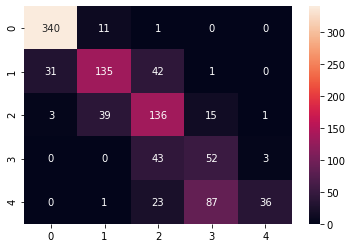

In [ ]:
sns.heatmap(confusion_matrix(list(valid_set['diagnosis'].astype('int64')),y_pred),annot=True, fmt="d")